In [18]:
from SyntheticControlMethods import Synth, DiffSynth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Read in the data
df = pd.read_csv('Data/data.csv')

In [12]:
df

,state,year,cigsale,lnincome,beer,age15to24,retprice
0,Alabama,1970,89.8,NaN,NaN,0.178862,39.6
1,Alabama,1971,95.4,NaN,NaN,0.179928,42.7
2,Alabama,1972,101.1,9.498476,NaN,0.180994,42.3
3,Alabama,1973,102.9,9.550107,NaN,0.182060,42.1
4,Alabama,1974,108.2,9.537163,NaN,0.183126,43.1
...,...,...,...,...,...,...,...
1204,Wyoming,1996,110.3,10.016768,24.6,NaN,162.5
1205,Wyoming,1997,108.8,10.025613,24.6,NaN,164.1
1206,Wyoming,1998,102.9,NaN,NaN,NaN,168.8
1207,Wyoming,1999,104.8,NaN,NaN,NaN,189.6


In [15]:
# Fit syntehtic control (covariates are averaged in the pre-treatment period)
synth_control = Synth(dataset=df, outcome_var='cigsale', id_var='state', time_var='year', treatment_period=1989, treated_unit='California', n_optim=100)

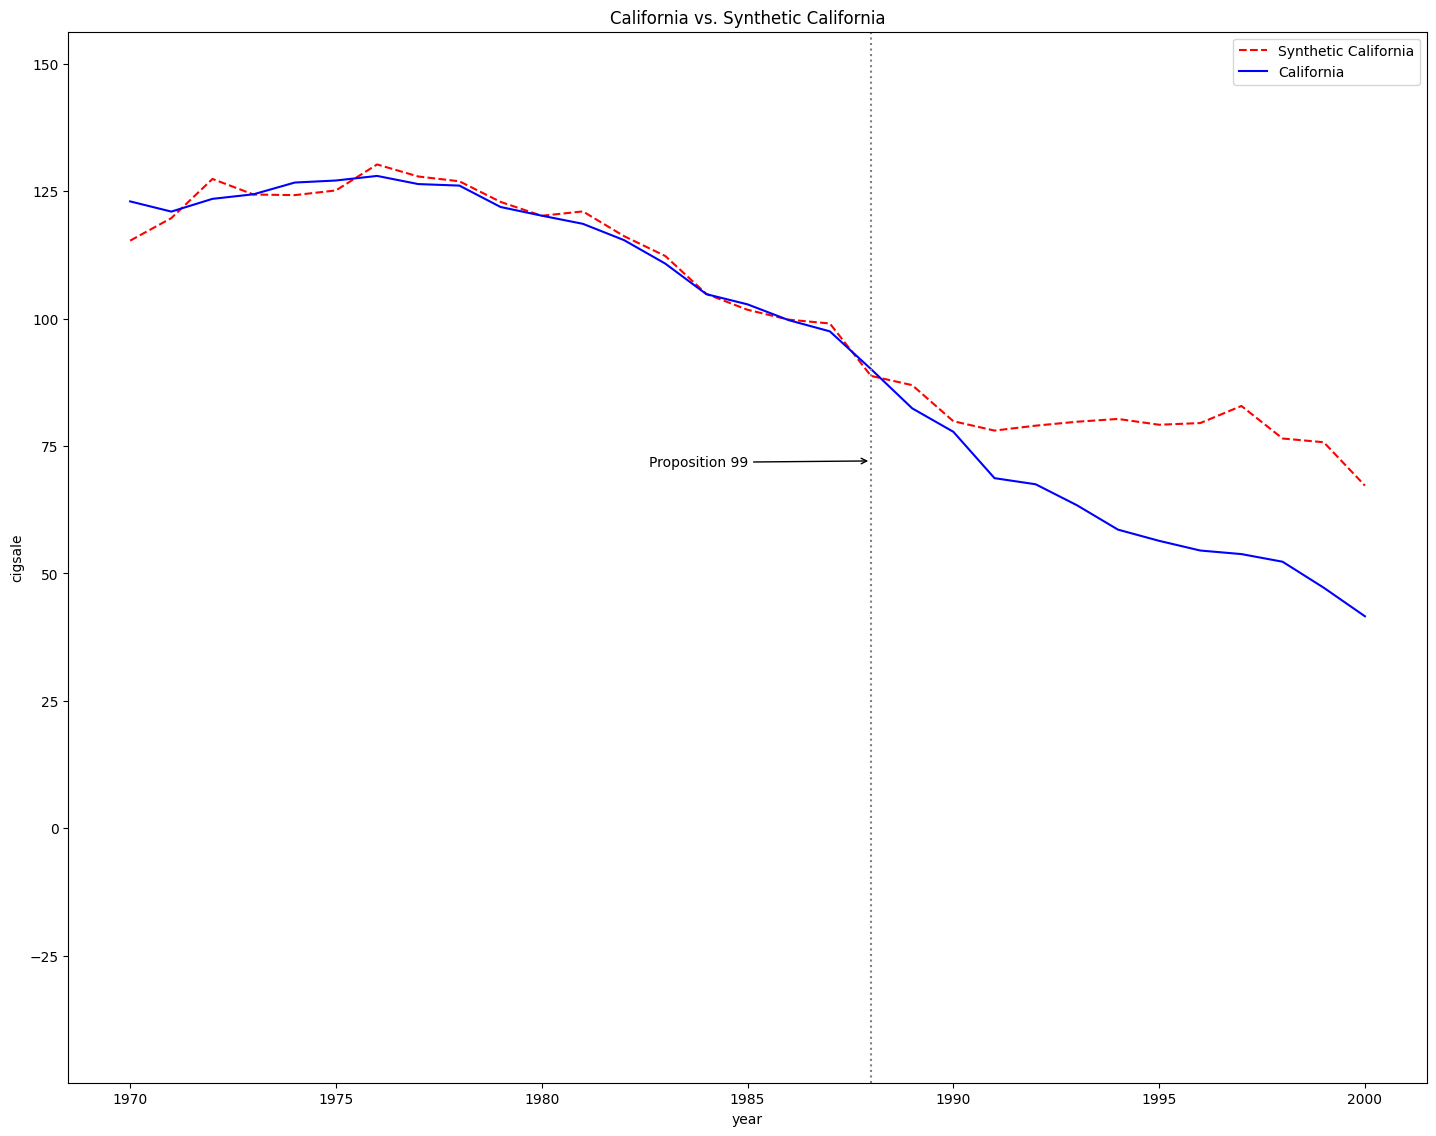

In [20]:
# Visualize
synth_control.plot(["original"], treated_label="California", 
            synth_label="Synthetic California", treatment_label="Proposition 99")

In [29]:
print(synth_control.original_data.__dict__)

{'dataset':         state  year  cigsale   lnincome  beer  age15to24  retprice
 0     Alabama  1970     89.8        NaN   NaN   0.178862      39.6
 1     Alabama  1971     95.4        NaN   NaN   0.179928      42.7
 2     Alabama  1972    101.1   9.498476   NaN   0.180994      42.3
 3     Alabama  1973    102.9   9.550107   NaN   0.182060      42.1
 4     Alabama  1974    108.2   9.537163   NaN   0.183126      43.1
 ...       ...   ...      ...        ...   ...        ...       ...
 1204  Wyoming  1996    110.3  10.016768  24.6        NaN     162.5
 1205  Wyoming  1997    108.8  10.025613  24.6        NaN     164.1
 1206  Wyoming  1998    102.9        NaN   NaN        NaN     168.8
 1207  Wyoming  1999    104.8        NaN   NaN        NaN     189.6
 1208  Wyoming  2000     90.5        NaN   NaN        NaN     267.1
 
 [1209 rows x 7 columns],
 'outcome_var': 'cigsale',
 'id': 'state',
 'time': 'year',
 'treatment_period': 1989,
 'treated_unit': 'California',
 'control_units': array(['A